In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prepData import *
from math import sqrt
from plotterUtils import *

In [2]:
df_perjet = jet_level_data()
df_perjet = df_perjet.astype(np.float32)

In [3]:
factorNames = [  'jet_pt_ak7',
                 'jet_eta_ak7',
                 'jet_photonFrac_ak7',
                 'jet_electronFrac_ak7',
                 'jet_muonFrac_ak7',
                 'jet_neuHadronFrac_ak7',
                 'jet_charHadronFrac_ak7',
                 'jet_electronMult_ak7',
                 'jet_muonMult_ak7',
                 'jet_photonMult_ak7',
                 'jet_neuHadronMult_ak7',
                 'jet_charHadronMult_ak7'
              ]

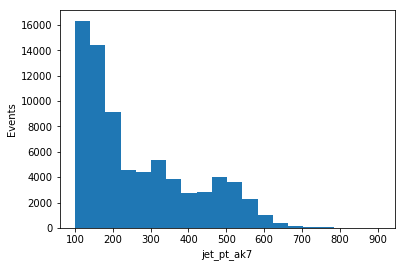

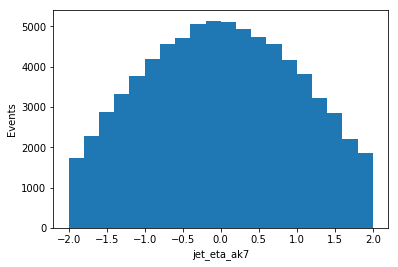

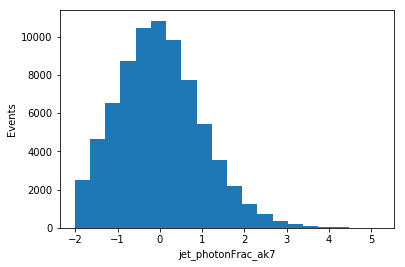

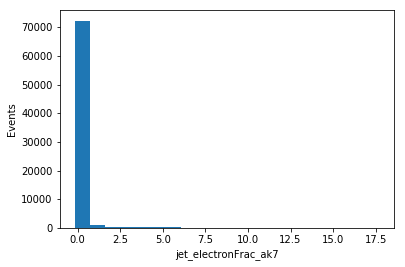

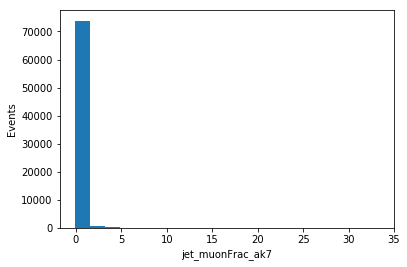

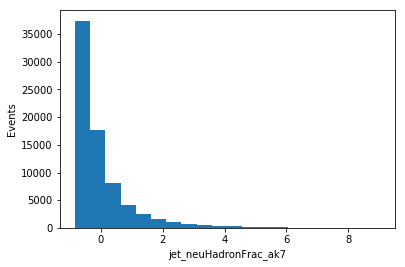

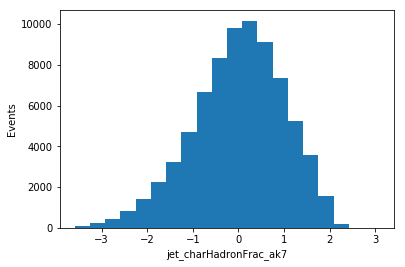

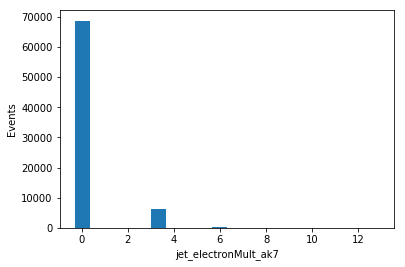

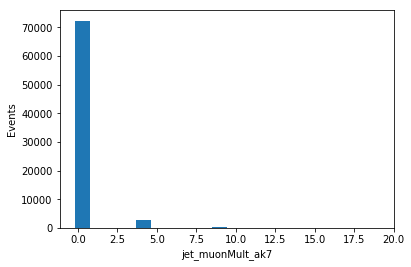

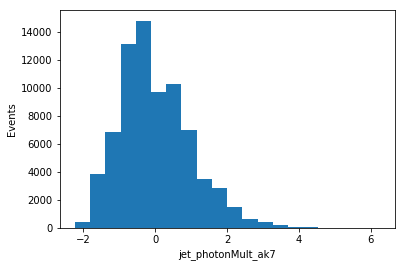

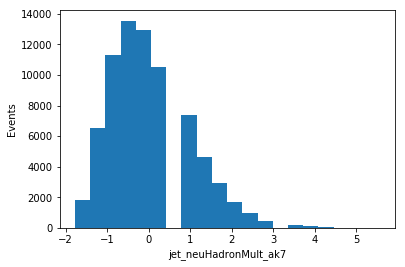

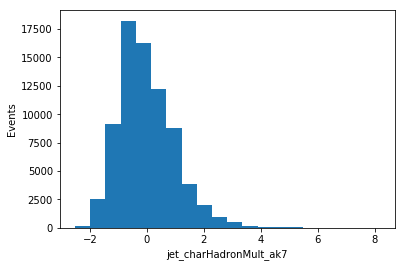

In [4]:
scaleData = True
if( scaleData ):
    means = df_perjet.mean()
    rmss = df_perjet.std()

    normalFactors = [
                  #'jet_eta_ak7',
                  'jet_photonFrac_ak7',
                  'jet_electronFrac_ak7',
                  'jet_muonFrac_ak7',
                  'jet_neuHadronFrac_ak7',
                  'jet_charHadronFrac_ak7',
                  'jet_electronMult_ak7',
                  'jet_muonMult_ak7',
                  'jet_photonMult_ak7',
                  'jet_neuHadronMult_ak7',
                  'jet_charHadronMult_ak7'
                    ]

    for f in normalFactors:
        df_perjet[f] = map(lambda x : (x-means[f])/rmss[f],df_perjet[f])

    for i,f in enumerate(factorNames):
        plt.hist(df_perjet[f],20)
        plt.xlabel(f)
        plt.ylabel("Events")
        plt.show()

In [5]:
df_train,df_test = np.array_split(df_perjet,2)

In [6]:
# Parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 1024
display_step = 10

# Network Parameters
n_hidden_1 = 1000 # 1st layer number of features
n_hidden_2 = 1000 # 2nd layer number of features
n_input = len(factorNames) # MNIST data input (img shape: 28*28)

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, 1])

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    #layer_1 = tf.matmul(x,weights['h1'])
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.tanh(layer_1)
    # Hidden layer with RELU activation
    #layer_2 = tf.matmul(layer_1, weights['h2'])
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.tanh(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    #out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

In [7]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, 1]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([1]))
}

In [8]:
# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.losses.mean_squared_error(pred,y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()


In [9]:
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
#     for epoch in range(training_epochs):
#         avg_cost = 0.
#         total_batch = int(len(df_train)/batch_size)
#         # Loop over all batches
#         for i in range(total_batch):
#             batch = df_train.loc[i:i+batch_size,:]
#             batch_x = batch[factorNames]
#             batch_y = batch['jet_jes_ak7']
#             # Run optimization op (backprop) and cost op (to get loss value)
    #_, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
    #                                              y: batch_y.reshape(len(batch_y),1)})
    _, c = sess.run([optimizer, cost], feed_dict={x: df_train[factorNames],
                                                  y: df_train['jet_jes_ak7'].values.reshape(len(df_train['jet_jes_ak7']),1)})

#         # Compute average loss
#             avg_cost += c / total_batch
#         # Display logs per epoch step
#         if epoch % display_step == 0:
#             print("Epoch:", '%04d' % (epoch+1), "cost=", \
#                 "{:.9f}".format(avg_cost))
    print sqrt(c)
    print("Optimization Finished!")
    
    df_train['prediction'] = sess.run(multilayer_perceptron(df_train[factorNames],weights,biases))
    df_train['residual'] = sess.run(tf.subtract(df_train['prediction'].values, df_train['jet_jes_ak7'].values))
    df_test['prediction'] = sess.run(multilayer_perceptron(df_test[factorNames],weights,biases))
    df_test['residual'] = sess.run(tf.subtract(df_test['prediction'].values, df_test['jet_jes_ak7'].values))
    print sess.run(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(df_train['prediction'].values, df_train['jet_jes_ak7'].values)))))
    print sess.run(tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(df_test['prediction'].values, df_test['jet_jes_ak7'].values)))))
    
    

43.5303919065
Optimization Finished!


TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type float64 of argument 'a'.

In [10]:
plt.scatter(df_test['prediction'],df_test['jet_jes_ak7'],s=1)
plt.show()

KeyError: 'prediction'

In [11]:
plt.hist(df_test['prediction'],bins=20)
plt.show()

KeyError: 'prediction'

In [12]:
plt.scatter(df_test['jet_pt_ak7'],df_test['residual'],s=1)
plt.show()
plt.scatter(df_test['jet_eta_ak7'],df_test['residual'],s=1)
plt.show()

KeyError: 'residual'